# Survival with MNIST

In this example, we will use the `PyTorch` lightning framework to further show how easy is it to use `TorchSurv`

### Dependencies

To run this notebooks, dependencies must be installed. the recommended method is to use our development conda environment (**preferred**). Instruction can be found [here](https://opensource.nibr.com/torchsurv/devnotes.html#set-up-a-development-environment-via-conda) to install all optional dependencies. The other method is to install only required packages using the command line below:


In [1]:
# Install only required packages (optional)
# %pip install lightning
# %pip install matplotlib
# %pip install torchvision

In [2]:
import matplotlib.pyplot as plt
import torch
import copy
import lightning as L
from torchvision.models import resnet18
from torchvision.transforms import v2
from torchsurv.loss.cox import neg_partial_log_likelihood
from torchsurv.loss.momentum import Momentum

/Users/corolth1/anaconda3/envs/torchsurv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# PyTorch boilerplate - see https://github.com/Novartis/torchsurv/blob/main/docs/notebooks/helpers_momentum.py
from helpers_momentum import MNISTDataModule, LitMomentum, LitMNIST

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
from lightning.pytorch import seed_everything

_ = seed_everything(123, workers=True)

Seed set to 123


In [6]:
# Detect available accelerator; Downgrade batch size if only CPU available
if any([torch.cuda.is_available(), torch.backends.mps.is_available()]):
    print("CUDA-enabled GPU/TPU is available.")
    BATCH_SIZE = 500  # batch size for training
else:
    print("No CUDA-enabled GPU found, using CPU.")
    BATCH_SIZE = 50  # batch size for training

CUDA-enabled GPU/TPU is available.


In [7]:
EPOCHS = 2  # number of epochs to train
FAST_DEV_RUN = None  # Quick prototype, comment line for full epochs training

## Experiment setup

For this experiment, here's are our assumptions:
* We are using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) as inputs. 
* The **observed digits becomes the time to event** (e.g., the picture of a nine becomes time=9).
* To prevent log(0) issue, all zeros are transformed as tens (**time 0 -> 10**)
* All samples experienced an event (**no censoring**)

In [8]:
# Transforms our images
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize(224, antialias=True),
        v2.Normalize(mean=(0,), std=(1,)),
    ]
)

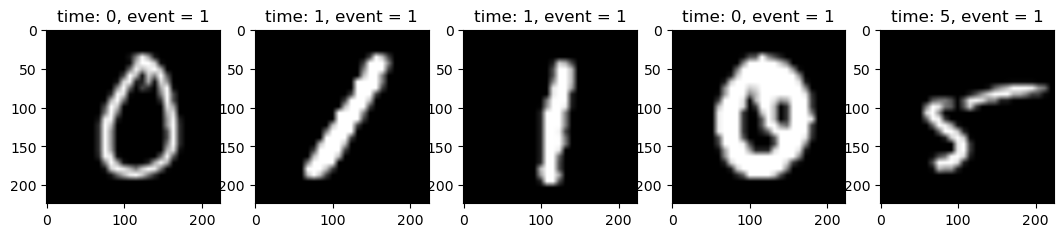

In [9]:
torch.manual_seed(42)

# Load datamodule
datamodule = MNISTDataModule(batch_size=BATCH_SIZE, transforms=transforms)
datamodule.prepare_data()  # Download the data
datamodule.setup()  # Wrangle the data

# print image examples, with label
x, y = next(iter(datamodule.train_dataloader()))

plt.rcParams["figure.figsize"] = [13, 5]
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x[i].squeeze(), cmap="gray")
    plt.title(f"time: {y[i]}, event = 1")

## Setup model backbone

First we need to define out model backbone. We will use the [resnet18](https://pytorch.org/hub/pytorch_vision_resnet/) model, without pretrained weights. We change two aspect of the model to fit our experiment:

* Changed the first convolution layer to **fit our grayscale images**
* Changed the last dense layer to output a single value (here `log hazard`)

In [10]:
resnet = resnet18(weights=None)
# Fits grayscale images
resnet.conv1 = torch.nn.Conv2d(
    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
)
# Output log hazards
resnet.fc = torch.nn.Linear(in_features=resnet.fc.in_features, out_features=1)

In [11]:
# Sanity checks
x = torch.randn((6, 1, 28, 28))  # Example batch of 6 MNIST images
print(f"{transforms(x).shape}")  # Check input dimension
print(f"{resnet(transforms(x)).shape}")  # Check output dimension

torch.Size([6, 1, 224, 224])
torch.Size([6, 1])


## Regular model training

For this experiment, we are using the trainer from [pytorch lightning](https://lightning.ai/docs/pytorch/2.1.3/starter/introduction.html). Most of the boilerplate code is under the hood, so we can focus on the ease of using the `TorchSurv` loss.

In [12]:
# Train first model (regular training) using our backbone
model_regular = LitMNIST(backbone=copy.deepcopy(resnet))

In [13]:
# Define trainer
trainer = L.Trainer(
    accelerator="auto",  # Use best accelerator
    logger=False,  # No logging
    enable_checkpointing=False,  # No model checkpointing
    limit_train_batches=0.1,  # Train on 10% of data
    max_epochs=EPOCHS,  # Train for EPOCHS
    fast_dev_run=FAST_DEV_RUN,
    deterministic=True,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
# Fit the model
trainer.fit(model_regular, datamodule)


  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Epoch 1: 100%|██████████| 11/11 [02:19<00:00,  0.08it/s, loss_step=226.0, val_loss_step=257.0, cindex_step=0.672, val_loss_epoch=256.0, cindex_epoch=0.676, loss_epoch=234.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 11/11 [02:19<00:00,  0.08it/s, loss_step=226.0, val_loss_step=257.0, cindex_step=0.672, val_loss_epoch=256.0, cindex_epoch=0.676, loss_epoch=234.0]


In [15]:
# Test the model
trainer.test(model_regular, datamodule)

Testing DataLoader 0: 100%|██████████| 20/20 [02:14<00:00,  0.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cindex_epoch          0.6842407584190369
     val_loss_epoch         -70.17123413085938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss_epoch': -70.17123413085938, 'cindex_epoch': 0.6842407584190369}]

# Momentum

For the the last part of the experiment, we are using the **same backbone model**, but now using a momentum loss. This loss allows to use previously computed batch value to increasing the effective loss samples. Details can be found [here](https://opensource.nibr.com/torchsurv/_autosummary/torchsurv.loss.momentum.html#module-torchsurv.loss.momentum).

The idea behind is fairly simple and inspired from [MoCo](https://arxiv.org/abs/1911.05722) to fit into a survival analysis. 

In [16]:
FACTOR = 10  # Number of batch to keep in memory. Increase our training batch size artificially by factor of 10 here
resnet_momentum = Momentum(
    copy.deepcopy(resnet), neg_partial_log_likelihood, steps=FACTOR, rate=0.999
)
model_momentum = LitMomentum(backbone=resnet_momentum)

# By using momentum, we can in theory reduce our batch size by factor and still have the same effective sample size
datamodule_momentum = MNISTDataModule(
    batch_size=BATCH_SIZE // FACTOR, transforms=transforms
)

In [17]:
# Define trainer
trainer = L.Trainer(
    accelerator="auto",  # Use best accelerator
    logger=False,  # No logging
    enable_checkpointing=False,  # No model checkpointing
    limit_train_batches=0.1,  # Train on 10% of data
    max_epochs=EPOCHS,  # Train for EPOCHS
    fast_dev_run=FAST_DEV_RUN,
    deterministic=True,
)
# Fit the model
trainer.fit(model_momentum, datamodule_momentum)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | Momentum | 22.3 M
-----------------------------------
11.2 M    Trainable params
11.2 M    Non-trainable params
22.3 M    Total params
89.366    Total estimated model params size (MB)


Epoch 1: 100%|██████████| 110/110 [04:34<00:00,  0.40it/s, loss_step=60.70, val_loss_step=60.50, cindex_step=0.736, val_loss_epoch=59.90, cindex_epoch=0.805, loss_epoch=62.30]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 110/110 [04:34<00:00,  0.40it/s, loss_step=60.70, val_loss_step=60.50, cindex_step=0.736, val_loss_epoch=59.90, cindex_epoch=0.805, loss_epoch=62.30]


In [18]:
# Validate the model
trainer.test(model_momentum, datamodule_momentum)

Testing DataLoader 0: 100%|██████████| 200/200 [04:26<00:00,  0.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      cindex_epoch          0.8023210763931274
     val_loss_epoch          91.81409454345703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss_epoch': 91.81409454345703, 'cindex_epoch': 0.8023210763931274}]

## Let's compare the two models

In [19]:
# Setup metics for each model
from torchsurv.metrics.cindex import ConcordanceIndex

cindex1 = ConcordanceIndex()  # Regular model
cindex2 = ConcordanceIndex()  # Momentum model

In [20]:
# Infere log hazards on unseen batch from test data
model_regular.eval()
model_momentum.eval()
with torch.no_grad():
    x, y = next(iter(datamodule.test_dataloader()))
    y[y == 0] = 10
    log_hz1 = model_regular(x)
    # For momentum, we advice to use the target network for inteference
    log_hz2 = model_momentum.model.target(x)

Despite training with batches 10x smaller than the regular model, the momentum model is performing better than the regular model on the same test batch.

In [21]:
print(f"Cindex (regular)  = {cindex1(log_hz1, torch.ones_like(y).bool(), y.float())}")
print(f"Cindex (momentum) = {cindex2(log_hz2, torch.ones_like(y).bool(), y.float())}")
# H1: cindex_momentum > cindex_regular, H0: same
print(f"Compare (p-value) = {cindex2.compare(cindex1)}")

Cindex (regular)  = 0.7037245035171509
Cindex (momentum) = 0.7813159823417664
Compare (p-value) = 0.0004994003102183342
